In [1]:
import re
import string
import nltk
import nlpaug.augmenter.word as naw
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


df = pd.read_csv('cybertroll.csv')
df.head()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dasad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dasad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dasad\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dasad\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dasad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,content,annotation
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook ...,1
2,why did you fuck it up. I could do it all day...,1
3,Dude they dont finish enclosing the fucking s...,1
4,WTF are you talking about Men? No men thats n...,1


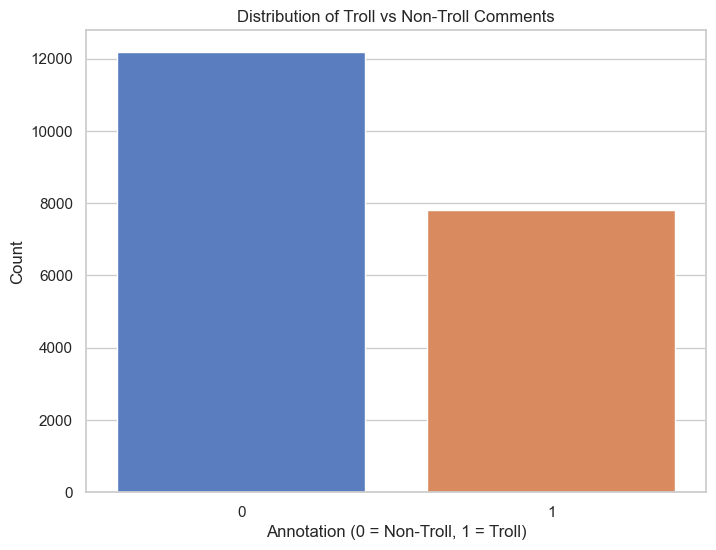

In [2]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='annotation', data=df, palette='muted')
plt.title('Distribution of Troll vs Non-Troll Comments')
plt.xlabel('Annotation (0 = Non-Troll, 1 = Troll)')
plt.ylabel('Count')
plt.show()


In [3]:
print("Sample Non-Troll Comments:")
print(df[df['annotation'] == 0]['content'].sample(3, random_state=42).tolist())

print("\nSample Troll Comments:")
print(df[df['annotation'] == 1]['content'].sample(3, random_state=42).tolist())


Sample Non-Troll Comments:
[" I was gonna dedicate my 850th tweet to you but then I was all FUCK  I already tweeted! But it was to you anyway so it's cool :D", ' today its warm though  crazy ass Cali weather', ' Fear. Only because of the corruptness of it all.']

Sample Troll Comments:
[' I brought Prussia back  bitch.', ' That sucks... Can you use it on your iphone?', ' yea dani thats kind of gay sorry to tel u lol']


In [4]:
# Dictionary for common contractions
contractions = {
    "can't": "cannot",
    "cant": "cannot",  # added uncontracted version
    "won't": "will not",
    "wont": "will not",  # added uncontracted version
    "i'm": "i am",
    "im": "i am",  # added uncontracted version
    "i've": "i have",
    "ive": "i have",  # added uncontracted version
    "i'll": "i will",
    "ill": "i will",  # added uncontracted version
    "you've": "you have",
    "youve": "you have",  # added uncontracted version
    "you'll": "you will",
    "youll": "you will",  # added uncontracted version
    "he's": "he is",
    "hes": "he is",  # added uncontracted version
    "she's": "she is",
    "shes": "she is",  # added uncontracted version
    "it's": "it is",
    "its": "it is",  # added uncontracted version
    "they're": "they are",
    "theyre": "they are",  # added uncontracted version
    "they've": "they have",
    "theyve": "they have",  # added uncontracted version
    "they'll": "they will",
    "theyll": "they will",  # added uncontracted version
    "we're": "we are",
    "weve": "we are",  # added uncontracted version
    "we've": "we have",
    "well": "we will",  # added uncontracted version
    "we'll": "we will",
    "thats": "that is",  # fixed spelling to be contraction-based
    "there's": "there is",
    "theres": "there is",  # added uncontracted version
    "what's": "what is",
    "whats": "what is",  # added uncontracted version
    "who's": "who is",
    "whos": "who is",  # added uncontracted version
    "how's": "how is",
    "hows": "how is",  # added uncontracted version
    "let's": "let us",
    "lets": "let us",  # added uncontracted version
    "haven't": "have not",
    "havent": "have not",  # added uncontracted version
    "hasn't": "has not",
    "hasnt": "has not",  # added uncontracted version
    "hadn't": "had not",
    "hadnt": "had not",  # added uncontracted version
    "don't": "do not",
    "dont": "do not",  # added uncontracted version
    "doesn't": "does not",
    "doesnt": "does not",  # added uncontracted version
    "didn't": "did not",
    "didnt": "did not",  # added uncontracted version
    "isn't": "is not",
    "isnt": "is not",  # added uncontracted version
    "aren't": "are not",
    "arent": "are not",  # added uncontracted version
    "wasn't": "was not",
    "wasnt": "was not",  # added uncontracted version
    "weren't": "were not",
    "werent": "were not",  # added uncontracted version
    "wouldn't": "would not",
    "wouldnt": "would not",  # added uncontracted version
    "shouldn't": "should not",
    "shouldnt": "should not",  # added uncontracted version
    "couldn't": "could not",
    "couldnt": "could not",  # added uncontracted version
    "mightn't": "might not",
    "mightnt": "might not",  # added uncontracted version
    "mustn't": "must not",
    "mustnt": "must not",  # added uncontracted version
    "needn't": "need not",
    "neednt": "need not",  # added uncontracted version
    "oughtn't": "ought not",
    "oughtnt": "ought not"  # added uncontracted version
}

def expand_contractions(text):
    for contraction, expansion in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text)
    return text


In [5]:
def preprocess_text(text):
    # 1. Expand contractions
    text = expand_contractions(text)
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 4. Lowercase the text
    text = text.lower()
    
    # 5. Tokenize the text
    tokens = word_tokenize(text)
    
    # 6. Stemming and Lemmatization
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    
    # 7. Join tokens back to string
    return ' '.join(lemmatized_tokens)

# Apply pre-processing
df['processed_content'] = df['content'].apply(preprocess_text)




In [6]:

df[['content', 'processed_content']]

,content,processed_content
0,Get fucking real dude.,get fuck real dude
1,She is as dirty as they come and that crook ...,she is a dirti a they come and that crook reng...
2,why did you fuck it up. I could do it all day...,whi did you fuck it up i could do it all day t...
3,Dude they dont finish enclosing the fucking s...,dude they do not finish enclos the fuck shower...
4,WTF are you talking about Men? No men thats n...,wtf are you talk about men no men that is not ...
...,...,...
19996,I dont. But what is complaining about it goin...,i do not but what is complain about it go to do
19997,Bahah yeah i&;m totally just gonna&; get pis...,bahah yeah im total just gon na get piss at yo...
19998,hahahahaha >:) im evil mwahahahahahahahahaha,hahahahaha i am evil mwahahahahahahahahaha
19999,What&;s something unique about Ohio? :),what someth uniqu about ohio


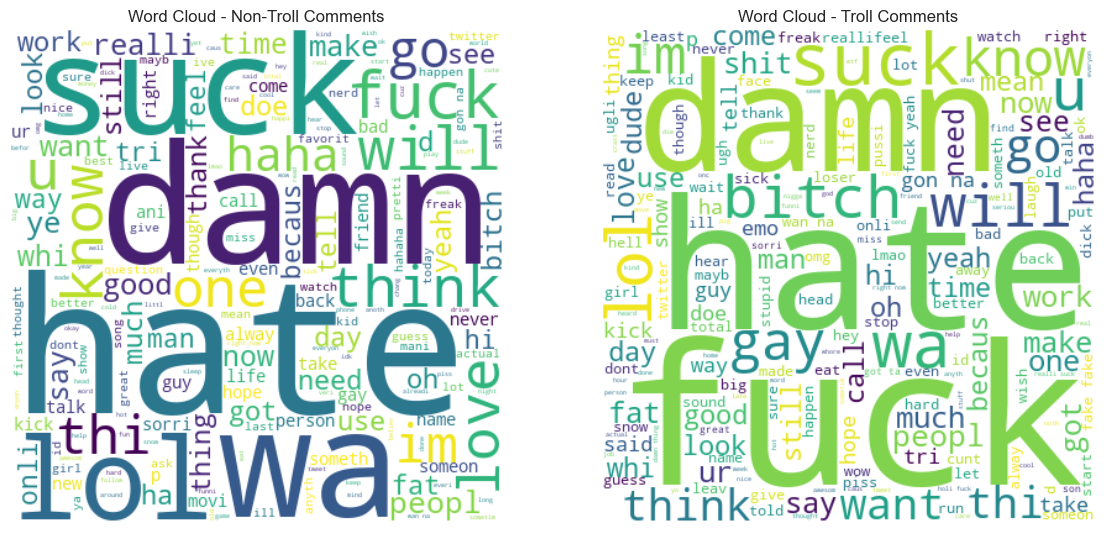

In [7]:
from wordcloud import WordCloud

# Combine all processed non-troll and troll comments
non_troll_text = ' '.join(df[df['annotation'] == 0]['processed_content'])
troll_text = ' '.join(df[df['annotation'] == 1]['processed_content'])

# Generate word clouds
plt.figure(figsize=(14, 7))

# Word cloud for non-troll comments
plt.subplot(1, 2, 1)
wordcloud_non_troll = WordCloud(width=400, height=400, background_color='white').generate(non_troll_text)
plt.imshow(wordcloud_non_troll, interpolation='bilinear')
plt.title('Word Cloud - Non-Troll Comments')
plt.axis('off')

# Word cloud for troll comments
plt.subplot(1, 2, 2)
wordcloud_troll = WordCloud(width=400, height=400, background_color='white').generate(troll_text)
plt.imshow(wordcloud_troll, interpolation='bilinear')
plt.title('Word Cloud - Troll Comments')
plt.axis('off')

plt.show()


In [8]:
import fasttext
import numpy as np
from tqdm import tqdm
import torch
from transformers import RobertaTokenizer, RobertaModel
from transformers import DistilBertModel, DistilBertTokenizer

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

# Load pre-trained FastText model (this is the FastText English model)
ft = fasttext.load_model('cc.en.300.bin')

# Function to get BERT embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    # Get embeddings from the [CLS] token
    embeddings = outputs.last_hidden_state[0, 0, :].cpu().numpy()  
    return embeddings

# Function to get FastText embeddings
def get_fasttext_embeddings(text):
    # FastText averages the word embeddings in the text
    words = text.split()
    embeddings = np.zeros(300)  # FastText embedding size is 300
    count = 0
    for word in words:
        embeddings += ft.get_word_vector(word)
        count += 1
    if count > 0:
        embeddings /= count  # Average the word embeddings
    return embeddings

# Initialize lists to hold individual and concatenated embeddings
bert_embeddings = []
fasttext_embeddings = []
final_embeddings = []


from sklearn.model_selection import train_test_split

# Split the data into training and test sets
df, tdf = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)


# Apply BERT and FastText embedding extraction with progress bar
for text in tqdm(df['processed_content'], desc="Extracting embeddings", unit="text"):
    # Get BERT and FastText embeddings
    bert_emb = get_bert_embeddings(text)
    fasttext_emb = get_fasttext_embeddings(text)
    
    # Store embeddings in their respective lists
    bert_embeddings.append(bert_emb)
    fasttext_embeddings.append(fasttext_emb)
    
    # Concatenate the embeddings and store them
    combined_emb = np.concatenate((bert_emb, fasttext_emb))  # 768 (BERT) + 300 (FastText) = 1068
    final_embeddings.append(combined_emb)

# Store embeddings in the DataFrame as separate columns
df['bert_embeddings'] = bert_embeddings
df['fasttext_embeddings'] = fasttext_embeddings
df['combined_embeddings'] = final_embeddings






Using device: cuda


Extracting embeddings: 100%|██████████| 16000/16000 [01:51<00:00, 143.75text/s]


In [9]:


bert_embeddings = []
fasttext_embeddings = []
final_embeddings = []

for text in tqdm(tdf['processed_content'], desc="Extracting embeddings", unit="text"):
    # Get BERT and FastText embeddings
    bert_emb = get_bert_embeddings(text)
    fasttext_emb = get_fasttext_embeddings(text)
    
    # Store embeddings in their respective lists
    bert_embeddings.append(bert_emb)
    fasttext_embeddings.append(fasttext_emb)
    
    # Concatenate the embeddings and store them
    combined_emb = np.concatenate((bert_emb, fasttext_emb))  # 768 (BERT) + 300 (FastText) = 1068
    final_embeddings.append(combined_emb)

# Store embeddings in the DataFrame as separate columns
tdf['bert_embeddings'] = bert_embeddings
tdf['fasttext_embeddings'] = fasttext_embeddings
tdf['combined_embeddings'] = final_embeddings

Extracting embeddings: 100%|██████████| 4001/4001 [00:26<00:00, 148.84text/s]


In [10]:
# Display a sample of the DataFrame to confirm the columns
df[['bert_embeddings', 'fasttext_embeddings', 'combined_embeddings']].head()

,bert_embeddings,fasttext_embeddings,combined_embeddings
3728,"[0.1022735, 0.18820788, 0.13460518, -0.2689462...","[0.07352071469358634, -0.02444631769321859, 0....","[0.10227350145578384, 0.18820787966251373, 0.1..."
8958,"[0.021759361, 0.03321235, 0.1480897, -0.350658...","[0.003041538435758816, -0.09166175458166334, -...","[0.021759361028671265, 0.03321234881877899, 0...."
7671,"[0.101552054, 0.06452165, 0.12828605, -0.24099...","[0.011697977238024274, -0.048179775269495115, ...","[0.10155205428600311, 0.06452164798974991, 0.1..."
5999,"[-0.071671225, -0.02387891, 0.044222787, -0.29...","[-0.010447046894114465, -0.1633432786911726, -...","[-0.07167122513055801, -0.023878909647464752, ..."
5751,"[0.15168822, 0.1693346, -0.0015775982, -0.3763...","[-5.095334257930517e-05, -0.055974117340520026...","[0.15168821811676025, 0.16933460533618927, -0...."


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CNNFeatureExtractor(nn.Module):
    def __init__(self, input_length=1068):
        super(CNNFeatureExtractor, self).__init__()
        
        # Small scale convolution (kernel size 3)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Medium scale convolution (kernel size 5)
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Large scale convolution (kernel size 7)
        self.conv3 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, padding=3)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
    
    def forward(self, x):
        # Small scale convolution
        x1 = self.conv1(x)
        x1 = F.relu(x1)
        x1 = self.pool1(x1)
        
        # Medium scale convolution
        x2 = self.conv2(x)
        x2 = F.relu(x2)
        x2 = self.pool2(x2)
        
        # Large scale convolution
        x3 = self.conv3(x)
        x3 = F.relu(x3)
        x3 = self.pool3(x3)
        
        # Concatenate the outputs
        x = torch.cat((x1, x2, x3), dim=1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        return x

def extract_cnn_features(df):
    # Initialize the feature extractor
    extractor = CNNFeatureExtractor()
    extractor.eval()  # Set to evaluation mode
    
    # Prepare to store features
    cnn_features_list = []
    
    # Process each embedding
    for embedding in df['combined_embeddings']:
        # Convert numpy array to tensor
        # Ensure shape is (1, 1, 1068)
        tensor_input = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # Extract features
        with torch.no_grad():
            features = extractor(tensor_input)
        
        # Convert to numpy and flatten
        cnn_features_list.append(features.numpy().flatten())
    
    # Store features in DataFrame
    df['cnn_features'] = cnn_features_list
    
    return df

# Usage
df = extract_cnn_features(df)
tdf = extract_cnn_features(tdf)

In [12]:
df

,content,annotation,processed_content,bert_embeddings,fasttext_embeddings,combined_embeddings,cnn_features
3728,no im just fucking pissed at shit,1,no i am just fuck piss at shit,"[0.1022735, 0.18820788, 0.13460518, -0.2689462...","[0.07352071469358634, -0.02444631769321859, 0....","[0.10227350145578384, 0.18820787966251373, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8958,Hey no big. It's not my ass that's showing.,0,hey no big it not my as that show,"[0.021759361, 0.03321235, 0.1480897, -0.350658...","[0.003041538435758816, -0.09166175458166334, -...","[0.021759361028671265, 0.03321234881877899, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7671,FOR REAL!!!! I NEED TO JUST STOP!!!! REALLY!!...,1,for real i need to just stop realli fuck,"[0.101552054, 0.06452165, 0.12828605, -0.24099...","[0.011697977238024274, -0.048179775269495115, ...","[0.10155205428600311, 0.06452164798974991, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5999,\It was not fun,1,it wa not fun,"[-0.071671225, -0.02387891, 0.044222787, -0.29...","[-0.010447046894114465, -0.1633432786911726, -...","[-0.07167122513055801, -0.023878909647464752, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5751,I also lost my wallet over the weekend! its s...,1,i also lost my wallet over the weekend it is s...,"[0.15168822, 0.1693346, -0.0015775982, -0.3763...","[-5.095334257930517e-05, -0.055974117340520026...","[0.15168821811676025, 0.16933460533618927, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
11284,lol oh that sucks but hv a safe flight,0,lol oh that suck but hv a safe flight,"[-0.17762002, 0.042227637, 0.12780632, -0.1442...","[0.032237127500896655, -0.11471241008904245, -...","[-0.1776200234889984, 0.04222763702273369, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11964,I know I hate that! It'd be one thing if App...,0,i know i hate that itd be one thing if appl tv...,"[0.2306216, 0.14989364, 0.3459949, -0.19497001...","[-0.029685757680924546, -0.05611792507336539, ...","[0.2306216061115265, 0.1498936414718628, 0.345...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5390,another downside to living in DSM but working...,1,anoth downsid to live in dsm but work in india...,"[-0.13669822, -0.009424791, 0.07895003, -0.219...","[-0.014025991472105185, -0.018301737184325855,...","[-0.13669821619987488, -0.009424790740013123, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
860,yeah dat bitch stabbed me in my eye when I wa...,1,yeah dat bitch stab me in my eye when i wa tri...,"[-0.18816896, 0.17949341, -4.531604e-05, -0.41...","[0.016874104627947275, -0.07995863033360556, -...","[-0.1881689578294754, 0.17949341237545013, -4....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

class FeatureTransformer(nn.Module):
    def __init__(self, input_dim):
        super(FeatureTransformer, self).__init__()
        
        # Shallow Fully Connected Network with ReLU
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
    
    def forward(self, x):
        return self.fc(x)

def extract_final_features(df):
    # Determine device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize feature transformer
    transformer = FeatureTransformer(
        input_dim=(
            len(df['bert_embeddings'].iloc[0]) + 
            len(df['fasttext_embeddings'].iloc[0]) + 
            len(df['cnn_features'].iloc[0])
        )
    ).to(device)
    
    # Prepare to store final features
    final_features_list = []
    
    # Progress bar
    for bert_emb, fasttext_emb, cnn_feat in tqdm(
        zip(df['bert_embeddings'], df['fasttext_embeddings'], df['cnn_features']), 
        total=len(df), 
        desc="Extracting Final Features"
    ):
        # Combine features
        combined_features = np.concatenate([bert_emb, fasttext_emb, cnn_feat])
        
        # Convert to tensor
        features_tensor = torch.tensor(combined_features, dtype=torch.float32).to(device)
        
        # Apply non-linear transformation
        with torch.no_grad():
            transformed_features = transformer(features_tensor).cpu().numpy()
        
        final_features_list.append(transformed_features)
    
    # Add to DataFrame
    df['final_extracted_features'] = final_features_list
    
    return df

# Usage
df = extract_final_features(df)
tdf = extract_final_features(tdf)

# Optional: Print feature dimensions to verify
print("BERT Embedding Dim:", len(df['bert_embeddings'].iloc[0]))
print("FastText Embedding Dim:", len(df['fasttext_embeddings'].iloc[0]))
print("CNN Feature Dim:", len(df['cnn_features'].iloc[0]))


Using device: cuda


Extracting Final Features: 100%|██████████| 16000/16000 [00:12<00:00, 1268.29it/s]


Using device: cuda


Extracting Final Features: 100%|██████████| 4001/4001 [00:03<00:00, 1225.15it/s]

BERT Embedding Dim: 768
FastText Embedding Dim: 300
CNN Feature Dim: 51264


In [14]:
df['final_extracted_features'][1].shape


(64,)

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy

def calculate_entropy(labels):
    """
    Calculate entropy of the labels
    """
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return entropy(probabilities, base=2)

def calculate_conditional_entropy(features, labels):
    """
    Calculate conditional entropy of labels given features
    """
    # Discretize features
    feature_bins = np.percentile(features, [25, 50, 75])
    digitized_features = np.digitize(features, feature_bins)
    
    # Separate labels by feature bins
    unique_bins = np.unique(digitized_features)
    conditional_entropies = []
    
    for bin_val in unique_bins:
        bin_mask = (digitized_features == bin_val)
        bin_labels = labels[bin_mask]
        
        if len(bin_labels) > 0:
            bin_entropy = calculate_entropy(bin_labels)
            conditional_entropies.append(bin_entropy)
    
    return np.mean(conditional_entropies) if conditional_entropies else 0

def calculate_information_gain(features, labels):
    """
    Calculate Information Gain for features
    """
    # Global entropy
    global_entropy = calculate_entropy(labels)
    
    # Conditional entropy
    conditional_entropy = calculate_conditional_entropy(features, labels)
    
    # Information Gain
    information_gain = global_entropy - conditional_entropy
    
    return information_gain

def ant_colony_feature_selection(features, labels, num_ants=10, num_iterations=20, alpha=1, beta=2):
    """
    Perform feature selection using Ant Colony Optimization
    """
    num_features = features.shape[1]
    
    # Calculate initial information gain for each feature
    feature_gains = np.array([calculate_information_gain(features[:, i], labels) for i in range(num_features)])
    
    # Initialize pheromone trails
    pheromones = np.ones(num_features)
    
    # Best solution tracking
    best_solution = None
    best_fitness = -np.inf
    
    for _ in range(num_iterations):
        ant_solutions = []
        ant_fitnesses = []
        
        for _ in range(num_ants):
            # Probabilistic feature selection
            selection_probabilities = (pheromones ** alpha) * (feature_gains ** beta)
            selection_probabilities /= selection_probabilities.sum()
            
            # Select features for this ant
            selected_features = np.random.choice(
                num_features, 
                size=max(1, int(num_features * 0.3)),  # Select ~30% of features
                replace=False, 
                p=selection_probabilities
            )
            
            # Evaluate solution
            subset_features = features[:, selected_features]
            fitness = np.mean([calculate_information_gain(subset_features[:, i], labels) for i in range(subset_features.shape[1])])
            
            ant_solutions.append(selected_features)
            ant_fitnesses.append(fitness)
        
        # Update best solution
        best_current_index = np.argmax(ant_fitnesses)
        if ant_fitnesses[best_current_index] > best_fitness:
            best_solution = ant_solutions[best_current_index]
            best_fitness = ant_fitnesses[best_current_index]
        
        # Pheromone update
        pheromones *= 0.5  # Evaporation
        for solution, fitness in zip(ant_solutions, ant_fitnesses):
            pheromones[solution] += fitness
    
    return best_solution

def select_features(df):
    # Prepare features and labels
    features = np.array(df['final_extracted_features'].tolist())
    labels = df['annotation'].values
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Feature selection
    selected_feature_indices = ant_colony_feature_selection(scaled_features, labels)
    
    # Select features
    df['selected_features'] = df['final_extracted_features'].apply(
        lambda x: np.array(x)[selected_feature_indices]
    )
    
    print(f"Selected {len(selected_feature_indices)} features out of 64")
    return df

# Usage
df = select_features(df)
tdf = select_features(tdf)

Selected 19 features out of 64
Selected 19 features out of 64


In [16]:
df

,content,annotation,processed_content,bert_embeddings,fasttext_embeddings,combined_embeddings,cnn_features,final_extracted_features,selected_features
3728,no im just fucking pissed at shit,1,no i am just fuck piss at shit,"[0.1022735, 0.18820788, 0.13460518, -0.2689462...","[0.07352071469358634, -0.02444631769321859, 0....","[0.10227350145578384, 0.18820787966251373, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0935562, 0.088683695, 0.031164043, -0.03084...","[0.045345835, -0.03228487, -0.030566508, 0.019..."
8958,Hey no big. It's not my ass that's showing.,0,hey no big it not my as that show,"[0.021759361, 0.03321235, 0.1480897, -0.350658...","[0.003041538435758816, -0.09166175458166334, -...","[0.021759361028671265, 0.03321234881877899, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.10863162, 0.09728006, 0.033110257, -0.03132...","[0.06473865, -0.044354215, -0.054539006, 0.028..."
7671,FOR REAL!!!! I NEED TO JUST STOP!!!! REALLY!!...,1,for real i need to just stop realli fuck,"[0.101552054, 0.06452165, 0.12828605, -0.24099...","[0.011697977238024274, -0.048179775269495115, ...","[0.10155205428600311, 0.06452164798974991, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.098831266, 0.09342222, 0.03756, -0.04003310...","[0.059017286, -0.04343524, -0.040354155, 0.024..."
5999,\It was not fun,1,it wa not fun,"[-0.071671225, -0.02387891, 0.044222787, -0.29...","[-0.010447046894114465, -0.1633432786911726, -...","[-0.07167122513055801, -0.023878909647464752, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.10354727, 0.099148035, 0.035672806, -0.0225...","[0.05425703, -0.0488343, -0.035385195, 0.01405..."
5751,I also lost my wallet over the weekend! its s...,1,i also lost my wallet over the weekend it is s...,"[0.15168822, 0.1693346, -0.0015775982, -0.3763...","[-5.095334257930517e-05, -0.055974117340520026...","[0.15168821811676025, 0.16933460533618927, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.108478315, 0.10254251, 0.021724, -0.0269495...","[0.061742187, -0.034345135, -0.041889966, 0.01..."
...,...,...,...,...,...,...,...,...,...
11284,lol oh that sucks but hv a safe flight,0,lol oh that suck but hv a safe flight,"[-0.17762002, 0.042227637, 0.12780632, -0.1442...","[0.032237127500896655, -0.11471241008904245, -...","[-0.1776200234889984, 0.04222763702273369, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.11088357, 0.100792244, 0.027539795, -0.0196...","[0.057467863, -0.05937609, -0.048731197, 0.014..."
11964,I know I hate that! It'd be one thing if App...,0,i know i hate that itd be one thing if appl tv...,"[0.2306216, 0.14989364, 0.3459949, -0.19497001...","[-0.029685757680924546, -0.05611792507336539, ...","[0.2306216061115265, 0.1498936414718628, 0.345...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.095908746, 0.12066106, 0.039230946, -0.0241...","[0.06582768, -0.019123137, -0.04015847, 0.0107..."
5390,another downside to living in DSM but working...,1,anoth downsid to live in dsm but work in india...,"[-0.13669822, -0.009424791, 0.07895003, -0.219...","[-0.014025991472105185, -0.018301737184325855,...","[-0.13669821619987488, -0.009424790740013123, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.10513716, 0.11006181, 0.029358, -0.02918834...","[0.0804215, -0.030406192, -0.06435864, 0.02057..."
860,yeah dat bitch stabbed me in my eye when I wa...,1,yeah dat bitch stab me in my eye when i wa tri...,"[-0.18816896, 0.17949341, -4.531604e-05, -0.41...","[0.016874104627947275, -0.07995863033360556, -...","[-0.1881689578294754, 0.17949341237545013, -4....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.107685454, 0.11434766, 0.024226483, -0.0333...","[0.05907307, -0.04676754, -0.047754865, 0.0093..."


In [17]:
df['selected_features'][33].shape

(19,)

In [18]:
import numpy as np
from scipy.special import softmax

def attention_based_weighting(feature_vector):
    """
    Implement the Attention-Based Weighting algorithm on a feature vector.
    
    Parameters:
    feature_vector (np.ndarray): A 1D numpy array representing the feature vector.
    
    Returns:
    np.ndarray: The aggregated feature vector after applying attention-based weighting.
    """
    # Step 2: Compute Importance Scores
    importance_scores = []
    for feature in feature_vector:
        importance_score = np.tanh(feature)
        importance_scores.append(importance_score)
    
    # Step 3: Normalize Scores Using Softmax
    normalized_scores = softmax(importance_scores)
    
    # Step 4: Apply Attention Weights
    weighted_features = feature_vector * normalized_scores
    
    # Step 5: Aggregate Weighted Features
    aggregated_feature = np.sum(weighted_features)
    
    return aggregated_feature

# Apply the attention-based weighting to the 'selected_features' column
df['aggregated_feature_vector'] = df['selected_features'].apply(attention_based_weighting)

tdf['aggregated_feature_vector'] = tdf['selected_features'].apply(attention_based_weighting)

In [19]:
df

,content,annotation,processed_content,bert_embeddings,fasttext_embeddings,combined_embeddings,cnn_features,final_extracted_features,selected_features,aggregated_feature_vector
3728,no im just fucking pissed at shit,1,no i am just fuck piss at shit,"[0.1022735, 0.18820788, 0.13460518, -0.2689462...","[0.07352071469358634, -0.02444631769321859, 0....","[0.10227350145578384, 0.18820787966251373, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0935562, 0.088683695, 0.031164043, -0.03084...","[0.045345835, -0.03228487, -0.030566508, 0.019...",-0.007491
8958,Hey no big. It's not my ass that's showing.,0,hey no big it not my as that show,"[0.021759361, 0.03321235, 0.1480897, -0.350658...","[0.003041538435758816, -0.09166175458166334, -...","[0.021759361028671265, 0.03321234881877899, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.10863162, 0.09728006, 0.033110257, -0.03132...","[0.06473865, -0.044354215, -0.054539006, 0.028...",-0.007187
7671,FOR REAL!!!! I NEED TO JUST STOP!!!! REALLY!!...,1,for real i need to just stop realli fuck,"[0.101552054, 0.06452165, 0.12828605, -0.24099...","[0.011697977238024274, -0.048179775269495115, ...","[0.10155205428600311, 0.06452164798974991, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.098831266, 0.09342222, 0.03756, -0.04003310...","[0.059017286, -0.04343524, -0.040354155, 0.024...",-0.006892
5999,\It was not fun,1,it wa not fun,"[-0.071671225, -0.02387891, 0.044222787, -0.29...","[-0.010447046894114465, -0.1633432786911726, -...","[-0.07167122513055801, -0.023878909647464752, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.10354727, 0.099148035, 0.035672806, -0.0225...","[0.05425703, -0.0488343, -0.035385195, 0.01405...",-0.006707
5751,I also lost my wallet over the weekend! its s...,1,i also lost my wallet over the weekend it is s...,"[0.15168822, 0.1693346, -0.0015775982, -0.3763...","[-5.095334257930517e-05, -0.055974117340520026...","[0.15168821811676025, 0.16933460533618927, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.108478315, 0.10254251, 0.021724, -0.0269495...","[0.061742187, -0.034345135, -0.041889966, 0.01...",-0.006809
...,...,...,...,...,...,...,...,...,...,...
11284,lol oh that sucks but hv a safe flight,0,lol oh that suck but hv a safe flight,"[-0.17762002, 0.042227637, 0.12780632, -0.1442...","[0.032237127500896655, -0.11471241008904245, -...","[-0.1776200234889984, 0.04222763702273369, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.11088357, 0.100792244, 0.027539795, -0.0196...","[0.057467863, -0.05937609, -0.048731197, 0.014...",-0.010628
11964,I know I hate that! It'd be one thing if App...,0,i know i hate that itd be one thing if appl tv...,"[0.2306216, 0.14989364, 0.3459949, -0.19497001...","[-0.029685757680924546, -0.05611792507336539, ...","[0.2306216061115265, 0.1498936414718628, 0.345...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.095908746, 0.12066106, 0.039230946, -0.0241...","[0.06582768, -0.019123137, -0.04015847, 0.0107...",-0.005445
5390,another downside to living in DSM but working...,1,anoth downsid to live in dsm but work in india...,"[-0.13669822, -0.009424791, 0.07895003, -0.219...","[-0.014025991472105185, -0.018301737184325855,...","[-0.13669821619987488, -0.009424790740013123, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.10513716, 0.11006181, 0.029358, -0.02918834...","[0.0804215, -0.030406192, -0.06435864, 0.02057...",-0.004591
860,yeah dat bitch stabbed me in my eye when I wa...,1,yeah dat bitch stab me in my eye when i wa tri...,"[-0.18816896, 0.17949341, -4.531604e-05, -0.41...","[0.016874104627947275, -0.07995863033360556, -...","[-0.1881689578294754, 0.17949341237545013, -4....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.107685454, 0.11434766, 0.024226483, -0.0333...","[0.05907307, -0.04676754, -0.047754865, 0.0093...",-0.009344


In [22]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Prepare X and y for train
X_train_selected = np.array(df['selected_features'].tolist())  # 19-dimensional selective features
X_train_aggregated = np.array(df['aggregated_feature_vector'].tolist())  # Single aggregated feature

# Combine the two feature arrays
X_train = np.hstack((X_train_selected, X_train_aggregated.reshape(-1, 1)))

# Target labels
y_train = df['annotation'].values  # 0 = Non-Troll, 1 = Troll

print(f"Train Feature Matrix Shape: {X_train.shape}")  # Should be (num_samples, 20)


Train Feature Matrix Shape: (16000, 20)


In [23]:
# Prepare X and y for test
X_test_selected = np.array(tdf['selected_features'].tolist())  # 19-dimensional selective features
X_test_aggregated = np.array(tdf['aggregated_feature_vector'].tolist())  # Single aggregated feature

# Combine the two feature arrays
X_test = np.hstack((X_test_selected, X_test_aggregated.reshape(-1, 1)))

# Target labels
y_test = tdf['annotation'].values  # 0 = Non-Troll, 1 = Troll

print(f"Test Feature Matrix Shape: {X_test.shape}")  # Should be (num_samples, 20)


Test Feature Matrix Shape: (4001, 20)


In [24]:
# Define base classifiers
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('nn', MLPClassifier(hidden_layer_sizes=(128,), max_iter=1000, random_state=42))
]

# Define meta-classifier
meta_classifier = LogisticRegression(random_state=42)

# Create the stacking classifier
stacked_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_classifier, cv=5)

# Train the stacked classifier on train data
stacked_clf.fit(X_train, y_train)

print("Training Complete!")


Training Complete!


### Training Metrics ###
Accuracy: 0.9956
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9755
           1       0.99      0.99      0.99      6245

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000



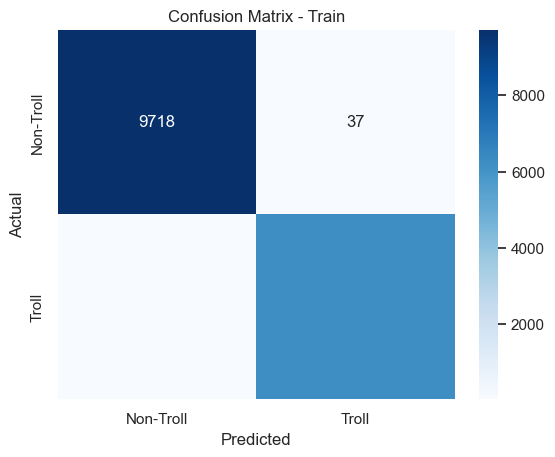

ROC-AUC: 0.9997
F1 Score: 0.9944
Precision: 0.9941
Recall: 0.9947


In [25]:
# Predict on training data
y_train_pred = stacked_clf.predict(X_train)
y_train_proba = stacked_clf.predict_proba(X_train)[:, 1]

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Advanced metrics
print("### Training Metrics ###")
print(f"Accuracy: {train_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Troll', 'Troll'], yticklabels=['Non-Troll', 'Troll'])
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC Score
train_auc = roc_auc_score(y_train, y_train_proba)
print(f"ROC-AUC: {train_auc:.4f}")

# F1 Score
train_f1 = f1_score(y_train, y_train_pred)
print(f"F1 Score: {train_f1:.4f}")

# Precision and Recall
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")



### Testing Metrics ###
Accuracy: 0.6058
Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.75      2424
           1       0.00      0.00      0.00      1577

    accuracy                           0.61      4001
   macro avg       0.30      0.50      0.38      4001
weighted avg       0.37      0.61      0.46      4001



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


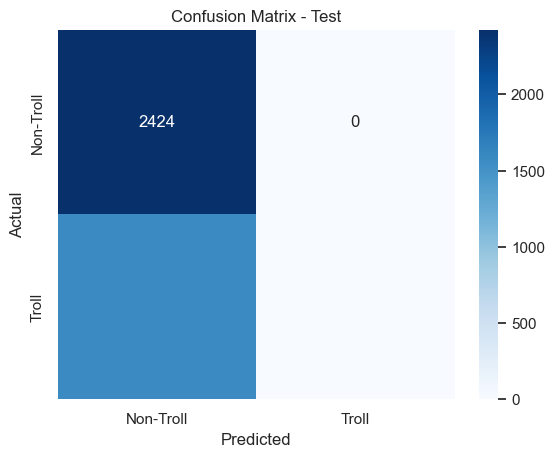

ROC-AUC: 0.5261
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000
Matthews Correlation Coefficient (MCC): 0.0000
Cohen's Kappa: 0.0000
Balanced Accuracy: 0.5000
Log Loss: 1.2478
Brier Score Loss: 0.3589
Average Precision Score: 0.4325


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


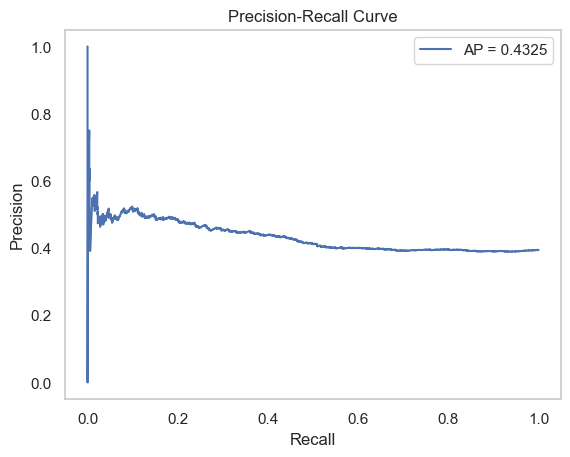

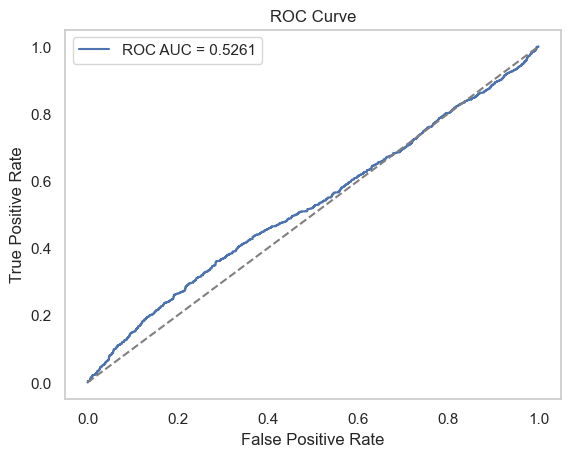

Hinge Loss: 1.0091


In [26]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    f1_score, precision_score, recall_score, roc_curve, precision_recall_curve,
    average_precision_score, matthews_corrcoef, cohen_kappa_score,
    balanced_accuracy_score, log_loss, hinge_loss, brier_score_loss
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Predict on test data
y_test_pred = stacked_clf.predict(X_test)
y_test_proba = stacked_clf.predict_proba(X_test)[:, 1]

# Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Classification Report
print("\n### Testing Metrics ###")
print(f"Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Troll', 'Troll'], yticklabels=['Non-Troll', 'Troll'])
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC Score
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC: {test_auc:.4f}")

# F1 Score
test_f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {test_f1:.4f}")

# Precision and Recall
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_test_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_test_pred)
print(f"Cohen's Kappa: {kappa:.4f}")

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# Log Loss
logloss = log_loss(y_test, y_test_proba)
print(f"Log Loss: {logloss:.4f}")

# Brier Score Loss (calibration of predicted probabilities)
brier = brier_score_loss(y_test, y_test_proba)
print(f"Brier Score Loss: {brier:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
average_precision = average_precision_score(y_test, y_test_proba)
print(f"Average Precision Score: {average_precision:.4f}")

plt.figure()
plt.plot(recall, precision, label=f'AP = {average_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Hinge Loss (for classifiers with hinge loss support like SVM)
try:
    hinge = hinge_loss(y_test, y_test_proba)
    print(f"Hinge Loss: {hinge:.4f}")
except ValueError:
    print("Hinge Loss not supported for this classifier.")
